In [1]:
import tensorflow as tf
tf.__version__

2022-05-26 10:11:54.671985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 10:11:54.672002: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.9.1'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
x_train = x_train / 255.
x_test = x_test / 255.

In [5]:
x_train.shape

(60000, 28, 28)

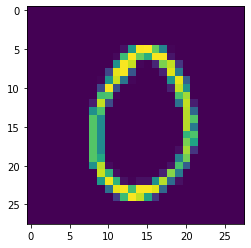

In [6]:
plt.imshow(x_train[210])

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

2022-05-26 10:11:56.492505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-26 10:11:56.492550: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-26 10:11:56.492569: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LXMU-GNHP733): /proc/driver/nvidia/version does not exist
2022-05-26 10:11:56.492868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.fit(
    x_train, y_train,
    epochs=5,
    validation_data=(x_test,y_test)
)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2593 - sparse_categorical_accuracy: 0.9251 - val_loss: 0.1469 - val_sparse_categorical_accuracy: 0.9580
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1139 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.0895 - val_sparse_categorical_accuracy: 0.9731
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0769 - sparse_categorical_accuracy: 0.9769 - val_loss: 0.0904 - val_sparse_categorical_accuracy: 0.9728
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0584 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.0964 - val_sparse_categorical_accuracy: 0.9691
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0454 - sparse_categorical_accuracy: 0.9862 - val_loss: 0.0890 - val_sparse_categorical_accuracy: 0.9731


In [9]:
y_pred = model.predict(x_test)

313/313 [==============================] - 0s 902us/step


In [10]:
np.argmax(y_pred[0])

7

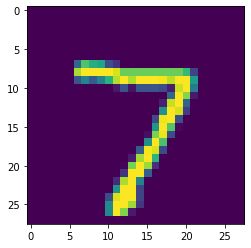

In [11]:
plt.imshow(x_test[0])